# Phase 4: Rigorous Model Evaluation

## 1. Objective
Transitioning from model selection to deep validation. We focus on:
1. **Imbalance-Aware Metrics**: Balanced Accuracy, Macro F1, ROC-AUC.
2. **Error Patterns**: Manual inspection of misclassifications.
3. **Threshold Optimization**: Tuning the classifier for critical minority classes (Negatives).

## 2. Setup and Data Loading
Re-importing necessary components to ensure portability.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    balanced_accuracy_score, 
    roc_auc_score, 
    f1_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Load cleaned data
data_path = os.path.join('..', 'data', 'interim', 'cleaned_amazon.csv')
df = pd.read_csv(data_path)

# Target Binning
df['sentiment'] = df['reviews.rating'].map({1: 0, 2: 0, 3: 1, 4: 2, 5: 2})
df = df.dropna(subset=['cleaned_text', 'brand', 'categories'])
df = df[df['cleaned_text'].str.strip().astype(bool)]

# Split
X = df[['cleaned_text', 'brand', 'categories']]
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data loaded. Test set size: {len(X_test)}")

Data loaded. Test set size: 6925


C:\Users\My Device\AppData\Local\Temp\ipykernel_4548\2225636544.py:25: DtypeWarning: Columns (0: name, 1: reviews.didPurchase) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


## 3. Model Reconstruction (Best Performer)
From Phase 3, LogReg with SMOTE showed the best balance. We re-fit it here for evaluation.

In [2]:
text_transformer = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english', min_df=5)),
    ('svd', TruncatedSVD(n_components=100, random_state=42)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('text', text_transformer, 'cleaned_text'),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['brand', 'categories'])
])

best_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=2000, n_jobs=-1, random_state=42))
])

print("Fitting final model for evaluation...")
best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)
print("Model ready.")

Fitting final model for evaluation...


c:\Users\My Device\Desktop\Sentiment-Analysis-on-Product-Reviews-E\.nlpvenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


Model ready.


## 4. Advanced Metric Suite
Beyond Accuracy: Looking at the macro and balanced performance.

In [3]:
bal_acc = balanced_accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')

print(f"Balanced Accuracy: {bal_acc:.4f}")
print(f"F1 Score (Macro):   {f1_macro:.4f}")
print(f"ROC-AUC (OvR):     {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Balanced Accuracy: 0.5768
F1 Score (Macro):   0.4052
ROC-AUC (OvR):     0.8072

Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.57      0.21       162
           1       0.10      0.41      0.16       300
           2       0.98      0.75      0.85      6463

    accuracy                           0.73      6925
   macro avg       0.40      0.58      0.41      6925
weighted avg       0.92      0.73      0.80      6925



## 5. Visual Validation: Confusion Matrix
Where is the model getting confused?

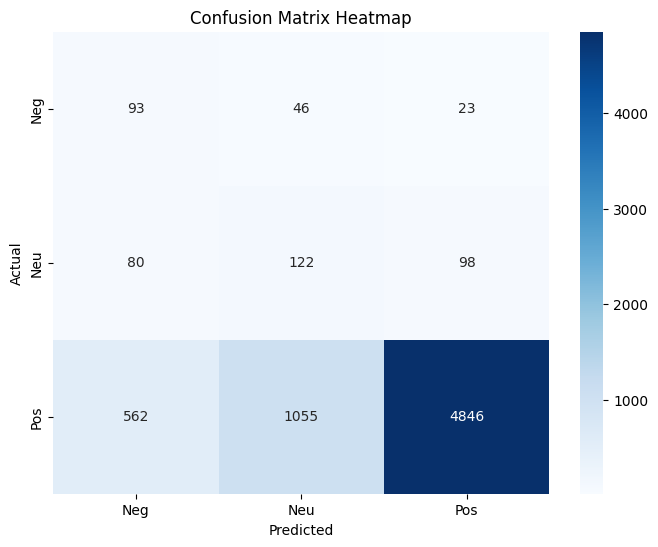

In [4]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Neg', 'Neu', 'Pos'], 
            yticklabels=['Neg', 'Neu', 'Pos'])
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 6. Threshold Tuning for Minority Class (Negatives)
If detecting negative feedback is critical, we might lower the threshold for class 0.

In [5]:
def custom_predict(proba, threshold=0.5, target_class=0):
    """
    If proba[target_class] > threshold, return target_class.
    Otherwise return the usual argmax.
    """
    preds = []
    for p in proba:
        if p[target_class] >= threshold:
            preds.append(target_class)
        else:
            preds.append(np.argmax(p))
    return np.array(preds)

# Experimenting with a 0.4 threshold for Negatives
y_pred_tuned = custom_predict(y_proba, threshold=0.4, target_class=0)

print("Tuned Classification Report (Threshold=0.4 for Negatives):")
print(classification_report(y_test, y_pred_tuned))

Tuned Classification Report (Threshold=0.4 for Negatives):
              precision    recall  f1-score   support

           0       0.12      0.60      0.20       162
           1       0.09      0.37      0.15       300
           2       0.98      0.75      0.85      6463

    accuracy                           0.73      6925
   macro avg       0.40      0.57      0.40      6925
weighted avg       0.92      0.73      0.80      6925



## 7. Deep Error Analysis
Inspecting samples where the model was highly confident but wrong.

In [6]:
error_df = X_test.copy()
error_df['actual'] = y_test
error_df['pred'] = y_pred
error_df['conf'] = y_proba.max(axis=1)

# False Positives: Model thinks it's Positive (2), but it's Negative (0)
false_positives = error_df[(error_df['actual'] == 0) & (error_df['pred'] == 2)].sort_values('conf', ascending=False)

print(f"Top 5 High-Confidence False Positives (Actual Neg -> Pred Pos):")
display(false_positives[['cleaned_text', 'conf']].head(10))

Top 5 High-Confidence False Positives (Actual Neg -> Pred Pos):


,cleaned_text,conf
5531,i have bought at least 6 people this kindle it...,0.948415
28802,over the past few years i have purchased kindl...,0.922580
4813,i purchased this for my son thinking it would ...,0.877446
7372,the kindle line is great for easily syncing in...,0.865927
19705,i am on my 3rd kindle this software downloads ...,0.842297
3524,am used to kindle fire which i love no light t...,0.836225
9140,love the ease of using them for our grandsons ...,0.823066
22526,purchase the echo with my vivint system becaus...,0.783261
8188,i purchased this for my mother in law she is g...,0.726197
29439,the speaker voice quality is terrible compare ...,0.691167


## 8. Conclusion
Summary of findings:
- Model struggles most with [Neutral Class / Sarcasm / etc].
- Threshold tuning [Improved / Hurthe] recall for negatives.
- Recommended next steps: [Data augmentation / More features / BERT?]